<a href="https://colab.research.google.com/github/sayed-shusan/Group-8/blob/master/bsl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BENGALI SIGN LANGUAGE RECOGNITION PROJECT**

# Setting up the environment

In [0]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s "/content/drive/My Drive/BSL" root
import os
os.chdir('root')

Mounted at /content/drive


**Importing tensorflow and checking tensorflow:**

In [0]:
%tensorflow_version 1.x
import tensorflow as tf

print(tf.__version__)

1.15.0


**Extracting the contents:**

In [0]:
!unzip -q -o -d /content bsl_alphabet.zip

# Looking at the dataset

**Specifying train and test directories:**

In [0]:
# Specifying the training and test directories

TRAINING_DIR = '/content/bsl_alphabet_train/bsl_alphabet_train/'
TEST_DIR = '/content/bsl_alphabet_test/bsl_alphabet_test/'

**Looking at some random images from the dataset:**

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)


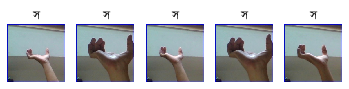

In [0]:
# Printing 5 random images from any training category or from a specified category
%matplotlib inline

import cv2
import os
import random
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

number_of_rows = 1
number_of_columns = 5

categories = os.listdir(TRAINING_DIR)
with open("classes.txt", "r") as f:
  class_names = f.read().split()
old_names = ['A', 'B', 'C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']

random.seed(13)

category = categories[random.randint(1, 30)]
from matplotlib import font_manager as fm, rcParams
fpath = "AdorshoLipi.ttf"
prop = fm.FontProperties(fname=fpath)
fname = fpath
for i in range(number_of_columns):
  subplot = plt.subplot(number_of_rows, number_of_columns, i + 1)
  subplot.axis('Off')
  subplot.set_title(class_names[int(category)-1], fontproperties=prop)
  image_path = os.path.join(
      TRAINING_DIR,
      str(category),
      old_names[int(category)-1] + str(random.randint(1, 1000)) + '.jpg'
  )
  image = mpimg.imread(image_path)
  plt.imshow(image)
  
plt.show()

# Preparing the training set

**Augmenting the data with brightness and zoom ranges:**

In [0]:
# Preparing ImageDataGenerator object for training the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 200
BATCH_SIZE = 64

data_generator = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization=True,
    brightness_range=[0.8, 1.0],
    zoom_range=[1.0, 1.2],
    validation_split=0.1
)

train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


# Preparing the model for training

**Downloading custom weight file if required:**

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-02-11 02:48:27--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/inception_ 100%[===================>]  83.84M   125MB/s    in 0.7s    

2020-02-11 02:48:28 (125 MB/s) - ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



**Preparing Inception V3 Network for transfer learning:**

In [0]:
# Loading inception v3 network for transfer learning
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3

WEIGHTS_FILE = '/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

inception_v3_model = InceptionV3(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), 
    include_top = False, 
    weights = 'imagenet'
)
inception_v3_model.load_weights(WEIGHTS_FILE)
model = inception_v3_model

# Enabling the top 2 inception blocks to train
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True
    
# Checking model summary to pick a layer (if required)
inception_v3_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
87916544/87910968 [==============================] - 2s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 9

**Choosing the inception output layer:**

In [0]:
# Choosing the output layer to be merged with our FC layers (if required)
inception_output_layer = inception_v3_model.get_layer('mixed7')
print('Inception model output shape:', inception_output_layer.output_shape)

# Not required --> inception_output = inception_output_layer.output
inception_output = inception_v3_model.output

Inception model output shape: (None, 10, 10, 768)


**Adding our own set of fully connected layers at the end of Inception v3 network:**

In [0]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

x = layers.GlobalAveragePooling2D()(inception_output)
x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dropout(0.2)(x)                  
x = layers.Dense(29, activation='softmax')(x)           

model = Model(inception_v3_model.input, x)
model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)

**Looking at the final model:**

In [0]:
# Watch the new model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

**Setting up a callback funtion in order to stop training at a particular threshold:**

In [0]:
# Creating a callback to stop model training after reaching a threshold accuracy

LOSS_THRESHOLD = 0.2
ACCURACY_THRESHOLD = 0.95

class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()

# Training the model generated using Inception v3 and our own set of Fully Connected layers

**Fitting the model to the training dataset:**

In [0]:
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    validation_steps=50,
    epochs=50,
    callbacks=[callback]
)

Epoch 1/50
100/100 [==============================] - 117s 1s/step - loss: 3.4065 - acc: 0.0498 - val_loss: 3.4809 - val_acc: 0.0453
Epoch 2/50
100/100 [==============================] - 103s 1s/step - loss: 3.2298 - acc: 0.1072 - val_loss: 3.4135 - val_acc: 0.0512
Epoch 3/50
100/100 [==============================] - 102s 1s/step - loss: 3.0924 - acc: 0.1994 - val_loss: 3.3550 - val_acc: 0.0653
Epoch 4/50
100/100 [==============================] - 102s 1s/step - loss: 2.9520 - acc: 0.2966 - val_loss: 3.3051 - val_acc: 0.0766
Epoch 5/50
100/100 [==============================] - 103s 1s/step - loss: 2.8112 - acc: 0.3759 - val_loss: 3.2496 - val_acc: 0.0934
Epoch 6/50
100/100 [==============================] - 103s 1s/step - loss: 2.6419 - acc: 0.4622 - val_loss: 3.2100 - val_acc: 0.1103
Epoch 7/50
100/100 [==============================] - 102s 1s/step - loss: 2.4852 - acc: 0.5125 - val_loss: 3.1516 - val_acc: 0.1359
Epoch 8/50
100/100 [==============================] - 102s 1s/step - 

# Plotting the results

**Training Accuracy vs Validation Accuracy:**

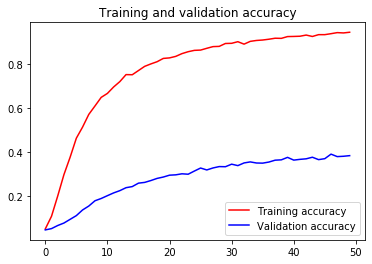

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

**Training Loss vs Validation Loss**

<Figure size 432x288 with 0 Axes>

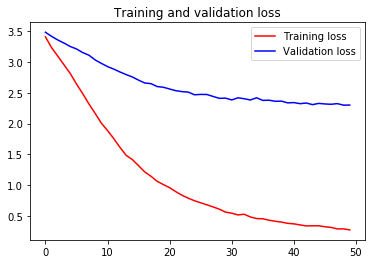

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

# Saving the model

**As we were satisfied with our results we save our model:**

In [0]:
# Saving the model
MODEL_NAME = 'models/bsl_alphabet_{}.h5'.format(9575)
model.save(MODEL_NAME)

# Testing our model

**Plotting images along with their respective actual and predicted classes:**

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Actual class: ছ 
 Predicted class: ছ


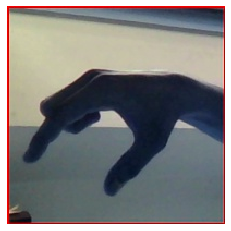

Actual class: থ 
 Predicted class: থ


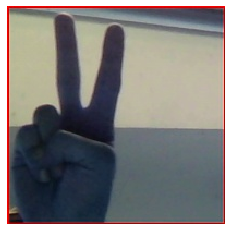

Actual class: ৎ 
 Predicted class: ৎ


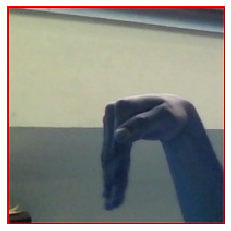

Actual class: অ 
 Predicted class: অ


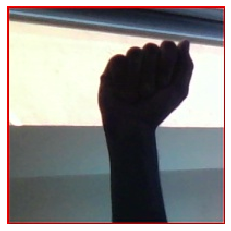

Actual class: দ 
 Predicted class: ঋ


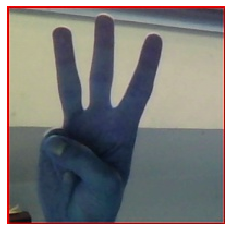

In [0]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
model = tf.keras.models.load_model('models/bsl_alphabet_9575.h5')
classes = os.listdir(TRAINING_DIR)
classes.sort()

for i, test_image in enumerate(os.listdir(TEST_DIR)):
    image_location = TEST_DIR + test_image
    img = cv2.imread(image_location)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    plt.figure()
    plt.axis('Off')
    plt.imshow(img)
    img = np.array(img) / 255.
    img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
    img = data_generator.standardize(img)
    prediction = np.array(model.predict(img))
    actual = class_names[int(test_image.split('_')[0])-1]
    predicted = class_names[int(classes[prediction.argmax()])-1]
    print('Actual class: {} \n Predicted class: {}'.format(actual, predicted))
    plt.show()

**Calculating test accuracy:**

In [0]:
test_images = os.listdir(TEST_DIR)
total_test_cases = len(test_images)
total_correctly_classified = 0
total_misclassified = 0
for i, test_image in enumerate(test_images):
    image_location = TEST_DIR + test_image
    img = cv2.imread(image_location)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = np.array(img) / 255.
    img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
    img = data_generator.standardize(img)
    prediction = np.array(model.predict(img))
    actual = class_names[int(test_image.split('_')[0])-1]
    predicted = class_names[int(classes[prediction.argmax()])-1]
    print('Actual class: {} - Predicted class: {}'.format(
        actual, predicted), end=' ')
    if actual == predicted:
      print('PASS!')
      total_correctly_classified += 1
    else:
      print('FAIL!')
      total_misclassified += 1
print("=" * 20)
test_accuracy = (total_correctly_classified / total_test_cases) * 100
test_error_rate = (total_misclassified / total_test_cases) * 100

print('Test accuracy (%):', test_accuracy)
print('Test error rate (%):', test_error_rate)
print('Number of misclassified classes:', total_misclassified)
print('Number of correctly classified classes', total_correctly_classified)